# Uninsured Idiosyncratic Risk and Aggregate Saving

Author: S. Rao Aiyagari

Quarterly Journal of Economics, 109(3):659–684

https://www.jstor.org/stable/2118417

Notebook by Adam Edwards

### Introduction

Aiyigari's 1994 paper introduces a Bewley model in which heterogenous agents face uninsurable idiosyncratic uncertainty in their income processes. Such uncertainty invokes precautionary saving on the part of the agents. Such models seek to examine the impact of uninsurable idiosyncratic risk on the saving behavior of agents, the aggregate saving rate, and inequality in wealth distributions.

### Model

The model is characterized by the following:

$$
\begin{split}
&\max E_0\left(\sum_{t=0}^\infty \beta^t U(c_t)\right)\\
&\text{s.t.}\\
&c_t+a_{t+1}=w\ell_{t}+(1+r)a_t \\
&c_t\geq0\\
&a_t\geq-\phi
\end{split}
$$

where $\phi$ (if positive) is the limit on borrowing; $\ell_t$ is assumed to be an i.i.d labor endowment shock with bounded support given by $[\ell_{min},\ell_{max}]$, $\ell_{min}>0$; and $w$ and $r$ represent the wage and interest rate repectively. The logarithm of the labor endowment shock follows an AR(1) process:

$$
\begin{split}
\log(\ell_t)=\rho\log(\ell_{t-1})+\sigma(1-\rho^2)^{\frac{1}{2}}\epsilon_{t}, \ \epsilon_t \sim N(0,1)
\end{split}
$$

The period utility function is assumed to be CRRA, $u(c) = \frac{c^{1-\mu} - 1}{1 - \mu}$.

I wish to find a steady state of this economy; that is, for each combination of parameters, I want to find an interest rate $r$ such that the saving behavior induced by $r$ generates capital levels that imply rental rate $r$. In other words, I am looking for a fixed point.

To illustrate, I will solve for the fixed point using the parameters of $\sigma = 0.2, \rho = 0.6, \mu = 3$. First I import necessary packages.


In [30]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from scipy.optimize import brentq

from HARK.ConsumptionSaving.ConsMarkovModel import MarkovConsumerType
from HARK.distribution import make_tauchen_ar1
from HARK.distribution import DiscreteDistributionLabeled
from HARK.utilities import plot_funcs

1. To begin tackling this problem I need to discretize the income process. Following Aiyagari, I will create a seven-state Markov chain using the Tauchen approximation to the AR1 process.


In [31]:
N = 7 # Number of income grid points
σ = 0.2
ρ = 0.6
μ = 3

shock_sd = lambda rho, sigma: sigma*(1-rho**2)**0.5

incomes, transition_matrix = make_tauchen_ar1(N, shock_sd(ρ, σ), ρ, 3)

2. Next, I will create a MarkovConsumerType with the desired parameters. The T and T_sum parameters define how many periods of the economy to simulate and to average over respectively.


In [32]:
T = 1000
T_sum = 700

AiyagariMarkovAgentDictionary = {
    "CRRA": 5.0,  # Coefficient of relative risk aversion
    "Rfree": 1.03,  # Interest factor on assets
    "DiscFac": 0.96,  # Intertemporal discount factor
    "LivPrb": [np.array(N * [1.0])],  # Survival probability
    "AgentCount": 1000,  # Number of agents of this type (only matters for simulation)
    "aNrmInitMean": 0.0,  # Mean of log initial assets (only matters for simulation)
    "aNrmInitStd": 1.0,  # Standard deviation of log initial assets (only for simulation)
    "PermGroFacAgg": 1.0,  # Aggregate permanent income growth factor (only matters for simulation)
    "T_age": None,  # Age after which simulated agents are automatically killed
    "T_cycle": 1,  # Number of periods in the cycle for this agent type
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin": 0.001,  # Minimum end-of-period "assets above minimum" value
    "aXtraMax": 20,  # Maximum end-of-period "assets above minimum" value
    # Some other value of "assets above minimum" to add to the grid
    "aXtraExtra": np.array([0.005, 0.01]),
    "aXtraNestFac": 3,  # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraCount": 48,  # Number of points in the grid of "assets above minimum"
    # Parameters describing the income process
    "UnempPrb": 0.0,  # Probability of unemployment while working
    "UnempPrbRet": 0.0,  # Probability of "unemployment" while retired
    "IncUnemp": 0.0,  # Unemployment benefits replacement rate
    "IncUnempRet": 0.0,  # "Unemployment" benefits when retired
    "tax_rate": 0.0,  # Flat income tax rate
    "T_retire": 0,  # Period of retirement (0 --> no retirement)
    "BoroCnstArt": 0.0,  # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "CubicBool": False,  # Use cubic spline interpolation when True, linear interpolation when False
    "vFuncBool": False,  # Whether to calculate the value function during solution
    "global_markv": False,
    "cycles": 0,
    "PermGroFac": [
        np.array(N * [1.0])
    ],
}

AiyagariMarkovAgentDictionaryCopy = deepcopy(AiyagariMarkovAgentDictionary)
AiyagariMarkovAgentDictionaryCopy["CRRA"] = μ
AiyagariMarkovAgentDictionaryCopy["MrkvArray"] = [transition_matrix]

AiyagariMarkovType = MarkovConsumerType(**AiyagariMarkovAgentDictionaryCopy)
AiyagariMarkovType.T_sim = T
AiyagariMarkovType.track_vars = ["aNrm", "cNrm", "TranShk"]
AiyagariMarkovType.MrkvPrbsInit = [1/N]*N

# This defines the labor endowements that the agents will be transitioning between
AiyagariMarkovType.IncShkDstn = [
    [DiscreteDistributionLabeled(pmv=np.ones(1), atoms=np.array([[1.0], [np.exp(x)]]), var_names=["PermShk", "TranShk"]) for x in incomes]
]

3. Now, simulate! Before I solve for the fixed point problem I will illustrate simulation. First, I will input an interest rate of 3% and calculate the resulting capital levels. I display the consumption functions and then the average level of assets during the simulation.


Consumption function by labor endowment level:


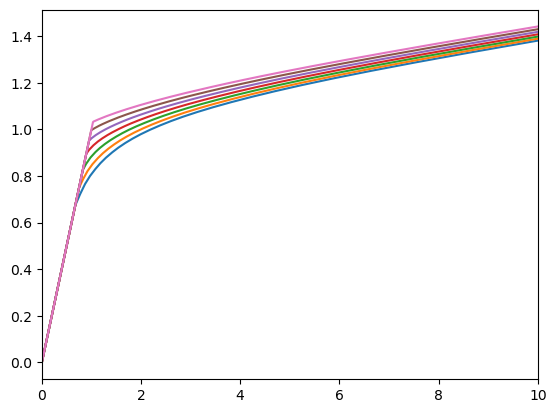

In [33]:
R = 1.03
AiyagariMarkovType.Rfree = np.array(np.array(N * [1.03]))

# Solve and simulate the agents
AiyagariMarkovType.solve()

print("Consumption function by labor endowment level:")
plot_funcs(AiyagariMarkovType.solution[0].cFunc, 0, 10)

Calculated average normalized aggregate capital between T_sum and T: 1640.4026822564745


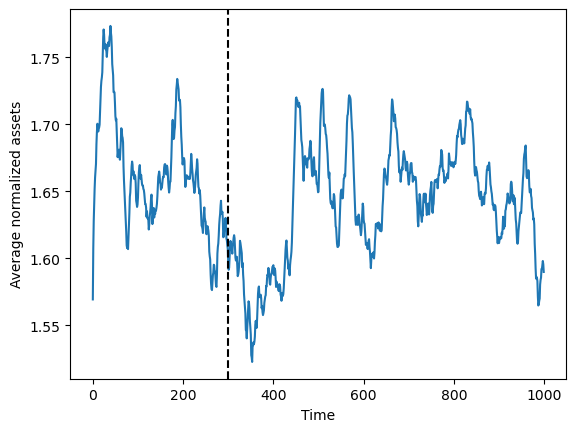

In [34]:
AverageAggregateVar = lambda var: np.mean(np.sum(var[T-T_sum:T-1], axis=1))

AiyagariMarkovType.make_shock_history()
AiyagariMarkovType.initialize_sim()
AiyagariMarkovType.simulate()
plt.plot(np.mean(AiyagariMarkovType.history["aNrm"], axis=1));
plt.axvline(x = T - T_sum, color = 'k', linestyle = 'dashed');
plt.xlabel("Time");
plt.ylabel("Average normalized assets");
print("Calculated average normalized aggregate capital between T_sum and T:", AverageAggregateVar(AiyagariMarkovType.history["aNrm"]))

Here I define functions useful for solving the fixed point problem. As in Aiyagari (1994), I define the capital share to be 0.36 and depreciation rate to be 0.08.


In [35]:
α = 0.36
δ = 0.08
RFunc = lambda k : 1.0 + α * k ** (α - 1.0) - δ
wFunc = lambda k: (1.0 - α) * k ** (α)
RFunc_inv = lambda R : ((R - 1.0 + δ)/α)**(1.0/(α - 1.0))

# This function takes an interest rate, simulates an economy with such an interest rate, and calculates the interest rates implied by aggregate saving. 
def CalculateImpliedR(R):
    wRte = wFunc(RFunc_inv(R))

    # Give the agents the proposed interest factor and calculate wage rate
    AiyagariMarkovType.Rfree = np.array(np.array(N * [R]))
    
    # Solve and simulate the agents
    AiyagariMarkovType.solve()
    AiyagariMarkovType.initialize_sim()
    AiyagariMarkovType.simulate()
    
    # Extract the agents' level of assets (capital holdings) and productivity at the end
    aNrm_agg = AverageAggregateVar(AiyagariMarkovType.history["aNrm"])
    pNrm_agg = AverageAggregateVar(AiyagariMarkovType.history["TranShk"])
    
    # Calculate aggregate capital and labor and take their ratio
    K = aNrm_agg*wRte # since assets are normalized, multiply by wage rate
    L = pNrm_agg
    k = K/L
    
    # Use the rule for determining Rfree to update the interest factor
    return RFunc(k)

def EquilibriumFunc(R):
    calculated = CalculateImpliedR(R)
    print("Input R:", R, "|| Implied R:", calculated, "|| Difference", calculated - R)
    return calculated - R

Solving for the equilibrium interest rate:


In [36]:
R_star = brentq(EquilibriumFunc, 0.99, 1.05)

Input R: 0.99 || Implied R: 1.368158766984903 || Difference 0.3781587669849029
Input R: 1.05 || Implied R: 0.9344308308246466 || Difference -0.11556916917535343
Input R: 1.0359555239988072 || Implied R: 1.082306624945198 || Difference 0.04635110094639083
Input R: 1.0399758787350055 || Implied R: 1.0123382670392653 || Difference -0.027637611695740194
Input R: 1.0384741226007204 || Implied R: 1.0406010307402955 || Difference 0.0021269081395751677
Input R: 1.0385814348423874 || Implied R: 1.0386199744744997 || Difference 3.853963211231104e-05
Input R: 1.038583412469969 || Implied R: 1.03858333932576 || Difference -7.314420913395736e-08
Input R: 1.0385834087237478 || Implied R: 1.0385834087281935 || Difference 4.445777079808977e-12
Input R: 1.0385834087247483 || Implied R: 1.0385834087096593 || Difference -1.5089041127680503e-11


In [37]:
cNrm_agg = AverageAggregateVar(AiyagariMarkovType.history["cNrm"])
aNrm_agg = AverageAggregateVar(AiyagariMarkovType.history["aNrm"])
pNrm_agg = AverageAggregateVar(AiyagariMarkovType.history["TranShk"])

income = (R_star - 1.0 + δ)*aNrm_agg + pNrm_agg

saving = (1 - cNrm_agg/income)*100   #convert to %
saving_rate = float("%.2f" % saving)  #with 2 decimals

interest = (R_star - 1)*100
interest_rate = float("%.4f" % interest)  #with 4 decimals

print("σ:", σ, "ρ:", ρ, "μ:", μ, "|| Interest rate:", interest_rate, "|| Aggregate saving rate:", saving_rate)

σ: 0.2 ρ: 0.6 μ: 3 || Interest rate: 3.8583 || Aggregate saving rate: 24.33


This result is very similar to Aiyagari (1994), who calculates the interest rate and saving rate for this combination of parameters as 3.8767 and 24.25 respectively. Now to solve for equilibrium interest rates for all combinations of parameters:


In [38]:
σ_values = [0.2, 0.4]
ρ_values = [0.0, 0.3, 0.6, 0.9]
μ_values = [1, 3, 5]
results = []

index = 0
for σ in σ_values:  
    for ρ in ρ_values:
        for μ in μ_values:
            incomes, transition_matrix = make_tauchen_ar1(N, shock_sd(ρ, σ), ρ, 3)

            AiyagariMarkovAgentDictionaryCopy = deepcopy(AiyagariMarkovAgentDictionary)
            AiyagariMarkovAgentDictionaryCopy["CRRA"] = μ
            AiyagariMarkovAgentDictionaryCopy["MrkvArray"] = [transition_matrix]

            AiyagariMarkovType = MarkovConsumerType(**AiyagariMarkovAgentDictionaryCopy)
            AiyagariMarkovType.T_sim = T
            AiyagariMarkovType.track_vars = ["aNrm", "cNrm", "TranShk"]
            AiyagariMarkovType.MrkvPrbsInit = [1/N]*N
            AiyagariMarkovType.IncShkDstn = [
                [DiscreteDistributionLabeled(pmv=np.ones(1), atoms=np.array([[1.0], [np.exp(x)]]), var_names=["PermShk", "TranShk"]) for x in incomes]
            ]

            print("σ:", σ, "ρ:", ρ, "μ:", μ)
            t = time.process_time()
            AiyagariMarkovType.make_shock_history()
            print("Time to generate shock history:", time.process_time() - t)

            R_star = brentq(EquilibriumFunc, 0.99, 1.05)

            cNrm_agg = AverageAggregateVar(AiyagariMarkovType.history["cNrm"])
            aNrm_agg = AverageAggregateVar(AiyagariMarkovType.history["aNrm"])
            pNrm_agg = AverageAggregateVar(AiyagariMarkovType.history["TranShk"])

            income = (R_star - 1.0 + δ)*aNrm_agg + pNrm_agg

            saving = (1 - cNrm_agg/income)*100   #convert to %
            saving_rate = float("%.2f" % saving)  #with 2 decimals

            interest = (R_star - 1)*100
            interest_rate = float("%.4f" % interest)  #with 4 decimals

            results.append([saving_rate, interest_rate])
            index = index + 1

            print("σ:", σ, "ρ:", ρ, "μ:", μ, "|| Interest rate:", interest_rate, "|| Aggregate saving rate:", saving_rate)
            print("")


σ: 0.2 ρ: 0.0 μ: 1
Time to generate shock history: 25.03125
Input R: 0.99 || Implied R: 1.9834427558406191 || Difference 0.9934427558406191
Input R: 1.05 || Implied R: 0.9208546096803382 || Difference -0.12914539031966188
Input R: 1.043097447674213 || Implied R: 0.9501203609596428 || Difference -0.09297708671457017
Input R: 1.0268717768776279 || Implied R: 1.5705686195499702 || Difference 0.5436968426723423
Input R: 1.04072792140492 || Implied R: 1.1464363331978678 || Difference 0.10570841179294765
Input R: 1.041988601527577 || Implied R: 0.9939139760088104 || Difference -0.04807462551876662
Input R: 1.04117254889729 || Implied R: 1.0930930244604795 || Difference 0.05192047556318946
Input R: 1.0415962680614355 || Implied R: 1.0344057598526524 || Difference -0.007190508208783086
Input R: 1.0415356599445942 || Implied R: 1.0423950369630637 || Difference 0.0008593770184694982
Input R: 1.0415421302508503 || Implied R: 1.0415256742130057 || Difference -1.6456037844614357e-05
Input R: 1.0415

In [40]:
aiyagari = [[23.67, 4.1666], [23.71, 4.1456], [23.83, 4.0858], [23.73, 4.1365], [23.91, 4.0432], [24.19, 3.9054], [23.82, 4.0912], [24.25, 3.8767], [24.86, 3.5857], [24.14, 3.9305], [25.51, 3.2903], [27.36, 2.5260], [23.87, 4.0649], [24.44, 3.7816], [25.22, 3.4177], [24.09, 3.9554], [25.22, 3.4188], [26.66, 2.8032], [24.5, 3.7567], [26.71, 2.7835], [29.37, 1.807], [25.47, 3.3054], [31.0, 1.2894], [37.63, -0.3456]]

conv = lambda x, y, xd, yd: ("%."+str(xd)+"f") % x + "/" + ("%."+str(yd)+"f") % y

row_names = {
    0:'ρ = 0',
    1:'ρ = 0.3',
    2:'ρ = 0.6',
    3:'ρ = 0.9'
}

def OutputTables(title, subtitle, operation_func, xd = 4, yd = 2):
    index = 0
    print(title)
    for sigma in range(1, 3):
        output = []
        for rho in range(1, 5):
            output_slice = []
            for theta in range(1, 4):
                r1, r2 = operation_func(results[index][0], results[index][1], aiyagari[index][0], aiyagari[index][1])
                if not r2 is None:
                    output_slice.append(conv(r1, r2, xd, yd))
                else:
                    output_slice.append(str(r1))
                index = index + 1
            output.append(output_slice)
        df = pd.DataFrame(output, columns=["µ = 1", "µ = 3", "µ = 5"])
        df = df.rename(index = row_names)
        print(subtitle + " (σ = " + str(0.2*sigma) + ")")
        print(df)
    print("\n")

def aiyagari_only(agg_s, r, A_agg_s, A_r):
    return A_r, A_agg_s

def results_only(agg_s, r, A_agg_s, A_r):
    return r, agg_s

OutputTables("Table II, Aiyagari (1994)", "Net return to capital in % / aggregate saving rate in %", aiyagari_only)
OutputTables("Table II, Replication (HARK)", "Net return to capital in % / aggregate saving rate in %", results_only)

def differences(agg_s, r, A_agg_s, A_r):
    return r - A_r, agg_s - A_agg_s

OutputTables("HARK minus Aiyagari (1994)", "Net return to capital in % / aggregate saving rate in %", differences)

Table II, Aiyagari (1994)
Net return to capital in % / aggregate saving rate in % (σ = 0.2)
                µ = 1         µ = 3         µ = 5
ρ = 0    4.1666/23.67  4.1456/23.71  4.0858/23.83
ρ = 0.3  4.1365/23.73  4.0432/23.91  3.9054/24.19
ρ = 0.6  4.0912/23.82  3.8767/24.25  3.5857/24.86
ρ = 0.9  3.9305/24.14  3.2903/25.51  2.5260/27.36
Net return to capital in % / aggregate saving rate in % (σ = 0.4)
                µ = 1         µ = 3          µ = 5
ρ = 0    4.0649/23.87  3.7816/24.44   3.4177/25.22
ρ = 0.3  3.9554/24.09  3.4188/25.22   2.8032/26.66
ρ = 0.6  3.7567/24.50  2.7835/26.71   1.8070/29.37
ρ = 0.9  3.3054/25.47  1.2894/31.00  -0.3456/37.63


Table II, Replication (HARK)
Net return to capital in % / aggregate saving rate in % (σ = 0.2)
                µ = 1         µ = 3         µ = 5
ρ = 0    4.1542/23.86  4.1108/23.94  4.0439/24.06
ρ = 0.3  4.1305/23.85  4.0267/24.05  3.8856/24.32
ρ = 0.6  4.0835/23.89  3.8583/24.33  3.5716/24.93
ρ = 0.9  3.9458/24.13  3.3377/25.41  2.6